<a href="https://colab.research.google.com/github/Maternowsky/Maternowsky/blob/main/Deep_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN's can automatically learn the features from raw data that are most useful for a particular task. It is common to consider CNN layers as feature extractors**

# **learning compute convolutions in one dimension**

In [2]:
import numpy as np
def conv1d(x, w, p=0, s=1):
  w_rot = np.array(w[::-1])
  x_padded = np.array(x)
  if p > 0:
    zero_pad = np.zeros(shape = p)
    x_padded = np.concatenate([zero_pad, x_padded, zero_pad])

  res = []
  for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
    res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
  return np.array(res)

## TESTING

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0 , 3, 1, 2]
print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]


In [3]:
print('NumPy Results:', np.convolve(x,w, mode = 'same'))

NumPy Results: [ 5 14 16 26 24 34 19 22]


# **Discrete concolution in 2D**

In [4]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0,0), s = (1,1)):
  W_rot = np.array(W)[::-1, ::-1]
  X_orig = np.array(X)
  n1 = X_orig.shape[0] + 2*p[0]
  n2 = X_orig.shape[1] + 2*p[1]
  X_padded = np.zeros(shape = (n1, n2))
  X_padded[p[0]:p[0]+X_orig.shape[0],
           p[1]:p[1]+X_orig.shape[1]] = X_orig
  res = []
  for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1,s[0]):
    res.append([])
    for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1,s[1]):
      X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
      res[-1].append(np.sum(X_sub*W_rot))
  return (np.array(res))



In [5]:
X = [[1,3,2,4],[5,6,1,3,],[1,2,0,2],[3,4,3,2]]
W = [[1,0,3], [1,2,1],[0,1,1]]

print('Conv2d Implementation:\n', conv2d(X,W, p =(1,1), s=(1,1)))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]


In [6]:
print('SciPy Results:\n', scipy.signal.convolve2d(X,W, mode='same'))

SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# **Subsampling layers- separate into pooling layers. Create new smaller matrix that is based on max or mean of smaller matrix. Makes more robust features less prone to noise and overfitting**

## **add the L2 penalty of a layer to the loss function in PyTorch**

In [7]:
import torch.nn as nn
import torch
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 5,
                       kernel_size = 5
                      )
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty
linear_layer = nn.Linear(10,16)
l2_penalty = l2_lambda*sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty= loss + l2_penalty

## **Using loss functions with two different formats. Logits or class-membership probabilities are given as inputs to the loss functions**

In [8]:
## Binary Cross-entropy

logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')

BCE (w Probas): 0.3711


In [9]:
print(f'BCE (w Logits): ' f'{bce_logits_loss_fn(logits, target):.4f}')

BCE (w Logits): 0.3711


In [10]:
## Categorical Cross-entropy

logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(f'CCE (w Logits): ' f'{cce_logits_loss_fn(logits, target):.4f}')

CCE (w Logits): 0.5996


In [11]:
print(f'CCE (w Probas): ' f'{cce_loss_fn(torch.log(probas), target):.4f}')

CCE (w Probas): 0.5996


# **Implementing a deep CNN using PyTorch**

## **Because number of channels(which 1 is for grayscale images) the input tensor's dimensions with be 'batchsize' x 28 x 28 x 1. The input data will go through two convolutional layers witha  kernel size of 5 x 5. first layer has 32 output feature maps and second has 64. For convolutional kernels were using stride = 1. for pooling layers were using kernel_size = 2**

# **Load and preprocessing data**

In [12]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST( root = image_path, train = True,
                                           transform = transform, download = True)
from torch.utils.data import Subset
mnist_valid_dataset= Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_datset = torchvision.datasets.MNIST(root = image_path, train=False,
                                               transform=transform, download = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 119703650.34it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83772955.62it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36211320.12it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4363382.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## **Construct Dataloader with batches of 64 images for training and validation set**

In [13]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size , shuffle = True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle = True)


# **Implement CNN using torch.nn. Default dimension for channels is NCHW format - N is number of images in batch, C for channels, H and W for height and width**

In [14]:
model = nn.Sequential()
model.add_module('conv1',nn.Conv2d( in_channels = 1, out_channels = 32,
                                   kernel_size=5, padding = 2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64,
                                    kernel_size=5, padding = 2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))

## **Calculating size of feature maps using PyTorch**

In [15]:
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 64, 7, 7])

### **input 4 images in the batch, 1 chanel, and image size of 28 x 28. output feature maps with 64 channels and spatial size of 7 x 7**

## **Add fully connected layer for implementing classifier on top of convolution and pooling layers. input to this layer must have rank 2, that is shape[batchsize x input_units]. Thus we flatten the output of previous layers**

In [16]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 3136])

## **add two fully connected layers with a dropout layer in between**

In [17]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout',  nn.Dropout(p = 0.5))
model.add_module('fc2', nn.Linear(1024, 10))

## **In practice, we usually use a softmax activation so probabilities sum to 1. However softmax is already used internally inside PyTorches 'CrossEntropyLoss' implementation. We will now create the loss function and optimizer for the model**

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **Adam optimizer is a robust, gradient- based optimizer suited to nonconvex optimization and ML problems**

## **Train the model by defining the following function**

In [19]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch]+= loss.item()*y_batch.size(0)
      is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)
    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim = 1) == y_batch).float()
        accuracy_hist_valid[epoch] += is_correct.sum()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f}'
    ' val_accuracy: ' f'{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

### **Train CNN model and use validation dataset for monitoring learning progress**

In [21]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9493 val_accuracy: 0.9825
Epoch 2 accuracy: 0.9839 val_accuracy: 0.9883
Epoch 3 accuracy: 0.9894 val_accuracy: 0.9889
Epoch 4 accuracy: 0.9911 val_accuracy: 0.9879
Epoch 5 accuracy: 0.9935 val_accuracy: 0.9897
Epoch 6 accuracy: 0.9947 val_accuracy: 0.9894
Epoch 7 accuracy: 0.9957 val_accuracy: 0.9870
Epoch 8 accuracy: 0.9957 val_accuracy: 0.9906
Epoch 9 accuracy: 0.9965 val_accuracy: 0.9903
Epoch 10 accuracy: 0.9965 val_accuracy: 0.9899
Epoch 11 accuracy: 0.9965 val_accuracy: 0.9909
Epoch 12 accuracy: 0.9979 val_accuracy: 0.9916
Epoch 13 accuracy: 0.9977 val_accuracy: 0.9897
Epoch 14 accuracy: 0.9976 val_accuracy: 0.9898
Epoch 15 accuracy: 0.9984 val_accuracy: 0.9881
Epoch 16 accuracy: 0.9973 val_accuracy: 0.9906
Epoch 17 accuracy: 0.9986 val_accuracy: 0.9894
Epoch 18 accuracy: 0.9979 val_accuracy: 0.9889
Epoch 19 accuracy: 0.9977 val_accuracy: 0.9917
Epoch 20 accuracy: 0.9985 val_accuracy: 0.9918


## **Visualize the learning curves**

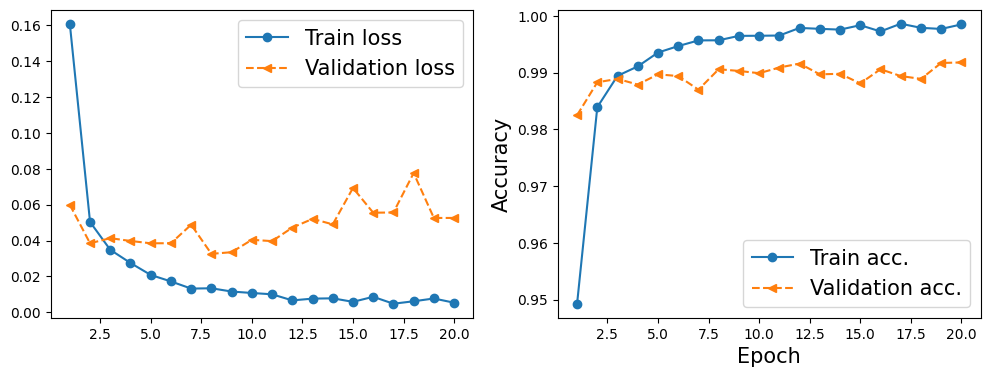

In [24]:
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) +1
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label = 'Train loss')
ax.plot(x_arr, hist[1], '--<', label = 'Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label = 'Train acc.')
ax.plot(x_arr, hist[3], '--<', label = 'Validation acc.')
ax.legend(fontsize = 15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size = 15)
plt.show()

## **Evaluate model on test dataset**

In [25]:
pred = model(mnist_test_datset.data.unsqueeze(1)/255)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_datset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9925


### **get prediction results in form of class-membership probabilities and convert them to predicted labels by using the 'torch.argmax' function. Do this for a batch of 12 examples**

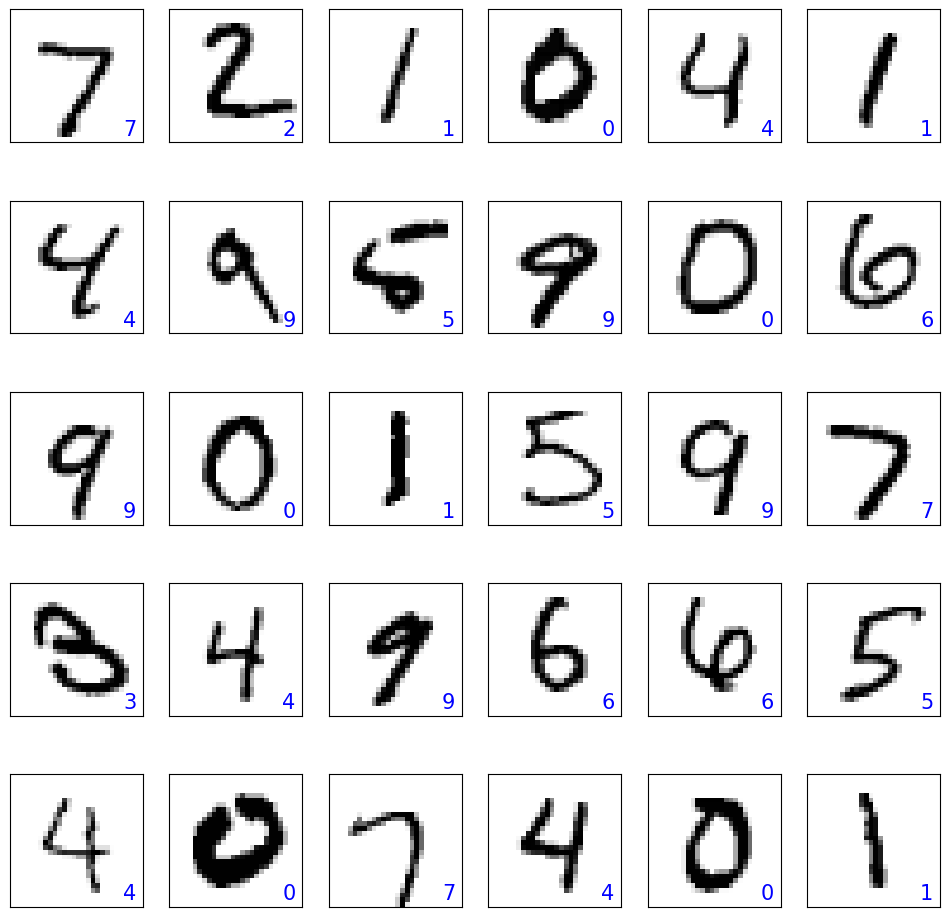

In [86]:

fig = plt.figure(figsize = (12, 12))
for i in range(30):
  ax = fig.add_subplot(5, 6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test_datset[i][0][0, :, :]
  pred = model(img.unsqueeze(0).unsqueeze(1))
  y_pred = torch.argmax(pred)
  ax.imshow(img, cmap='gray_r')
  ax.text(0.9, 0.1, y_pred.item(), size = 15, color = 'blue',
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
plt.show()

### **Plot failure cases**

In [92]:
pred = model(mnist_test_datset.data.unsqueeze(1)/255)
y_label = mnist_test_datset.targets
y_pred = torch.argmax(pred, dim = 1)
misclassify = []
i = 0
while i < len(y_label):
  if y_label[i].item() != y_pred[i].item():
    misclassify.append(i)
  i += 1


In [106]:
t = 0
while t <= 20:
  print('actual', y_label[t].item(), ' predict', y_pred[t].item(),'   t =', t)
  t += 1

actual 7  predict 7    t = 0
actual 2  predict 2    t = 1
actual 1  predict 1    t = 2
actual 0  predict 0    t = 3
actual 4  predict 4    t = 4
actual 1  predict 1    t = 5
actual 4  predict 4    t = 6
actual 9  predict 9    t = 7
actual 5  predict 5    t = 8
actual 9  predict 9    t = 9
actual 0  predict 0    t = 10
actual 6  predict 6    t = 11
actual 9  predict 9    t = 12
actual 0  predict 0    t = 13
actual 1  predict 1    t = 14
actual 5  predict 5    t = 15
actual 9  predict 9    t = 16
actual 7  predict 7    t = 17
actual 3  predict 3    t = 18
actual 4  predict 4    t = 19
actual 9  predict 9    t = 20


In [107]:
misclassify[:20]

[340,
 359,
 445,
 449,
 582,
 659,
 938,
 1014,
 1112,
 1114,
 1232,
 1242,
 1247,
 1260,
 1393,
 1414,
 1709,
 1901,
 2129,
 2130]

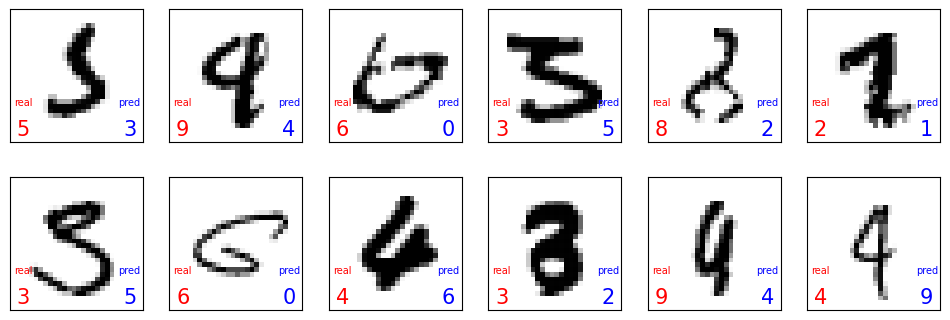

In [85]:
fig = plt.figure(figsize = (12, 4))
for i in range(12):
  ax = fig.add_subplot(2, 6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test_datset[misclassify[i]][0][0, :, :]
  pred = model(img.unsqueeze(0).unsqueeze(1))
  y_pred = torch.argmax(pred)
  ax.imshow(img, cmap='gray_r')
  ax.text(0.9, 0.1, y_pred.item(), size = 15, color = 'blue',
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
  ax.text(0.9, 0.3, 'pred', size = 7, color = 'blue',
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
  ax.text(0.1, 0.1, y_label[misclassify[i]].item(), size = 15,color = 'red',
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
  ax.text(0.1, 0.3, 'real', size = 7,color = 'red',
          horizontalalignment = 'center',
          verticalalignment = 'center',
          transform = ax.transAxes)
plt.show()